# Выбор локации для скважины

### Описание данных

* **id** — уникальный идентификатор скважины;  
* **f0**, **f1**, **f2** — три признака точек (неважно, что они означают, но сами признаки значимы);  
* **product** — объём запасов в скважине (тыс. баррелей).

### Условия задачи

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
* Бюджет на разработку скважин в регионе — 10 млрд рублей.  
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [45]:
# !pip install plotly

In [46]:
import os
import pandas as pd
import numpy as np
from numpy.random import RandomState

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings

In [47]:
warnings.filterwarnings('ignore')

In [48]:
RANDOM_STATE = 100500

In [49]:
directory = 'D:/work/jupyter/datasets'

Загрузим данные из 3-х датасетов, посмотрим на несколько строк.

In [50]:
df1 = pd.read_csv(os.path.join(directory, 'geo_data_0.csv'))
                  
df1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [51]:
df2 = pd.read_csv(os.path.join(directory, 'geo_data_1.csv'))
    
df2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [52]:
df3 = pd.read_csv(os.path.join(directory, 'geo_data_2.csv'))
    
df3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [53]:
# сохраним отдельно таргеты, они нам понадобятся в дальнейшем
target_1 = df1['product']
target_2 = df2['product']
target_3 = df3['product']
target_1

0        105.280062
1         73.037750
2         85.265647
3        168.620776
4        154.036647
            ...    
99995    110.744026
99996    122.346843
99997     64.375443
99998     74.040764
99999    149.633246
Name: product, Length: 100000, dtype: float64

In [54]:
# создадим функцию по предварительной обработке данных

def prep(data):
    
    print(data.info())
    
    # удаляем дубликаты, если они есть
    data = data.drop_duplicates().reset_index(drop=True)
    
    # удаляем столбец id - он будет мешать при обучении модели
    data = data.drop(['id'], axis=1)
    
    # строим гистограммы столбцов
    
    fig = plt.figure(figsize = (9, 9))
    ax = fig.gca()
    data.hist(bins=50, ax = ax)
    plt.show()
    
    display(data.describe())
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


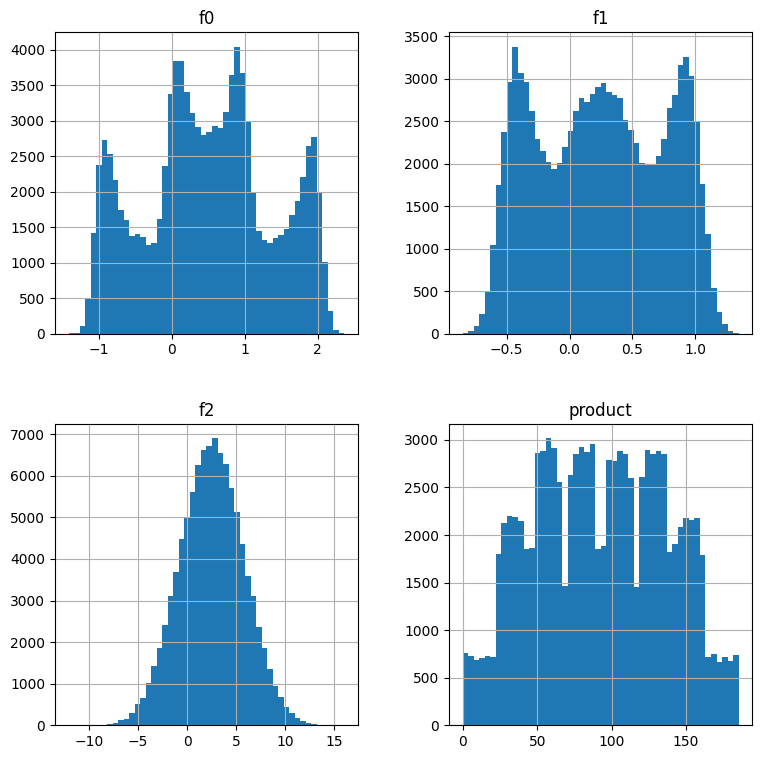

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [55]:
prep(df1)

Первый датасет соответствует наблюениям первого региона. Имеем 100 тыс строк, пропусков нет. У признаков f0 и f1 есть пики, f2 - нормально распределен. Целевой параметр product распределен приближенно нормально. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


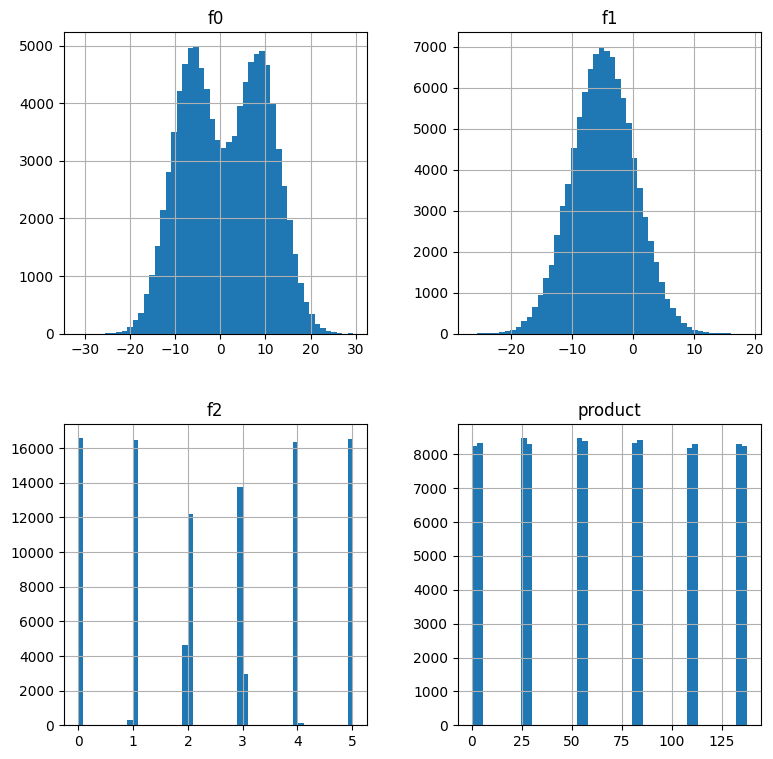

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [56]:
prep(df2)

Датасет второго региона также имеет 100 тыс наблюдений, пропусков в данных нет. Признак f0 распределен с 2 вершинами. У f1 четкое нормальное распределение. F2 и product распределены ненормально. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


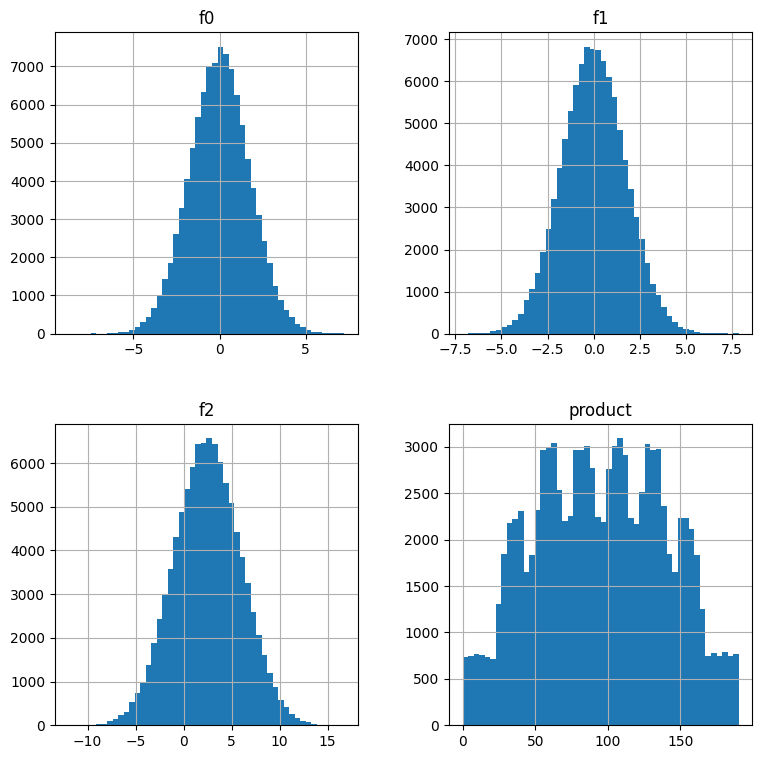

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [57]:
prep(df3)

У третьего региона датасет со 100 тыс. строками, без пропусков. Признаки f0, f1, f2 распределены нормально. Целевой признак product имеет распределение, близкое к нормальному. 

In [58]:
# создадим функцию корреляции признаков
def corr_features(data):
    upp_mat = np.triu(data.corr())
    sns.heatmap(data.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)

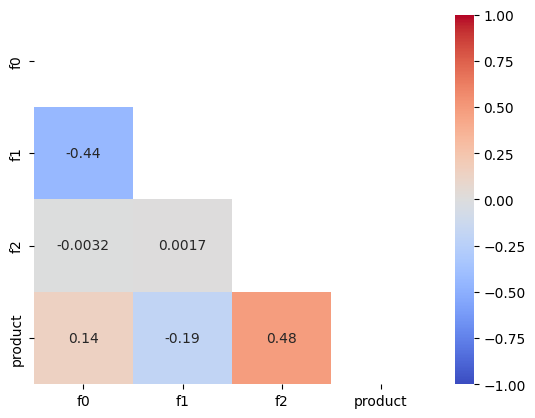

In [59]:
corr_features(df1)

Между собой у признаков максимальная корреляция -0.44 (f0 и f1). С целевым признаком максимальная корреляция у f2 (0.48).

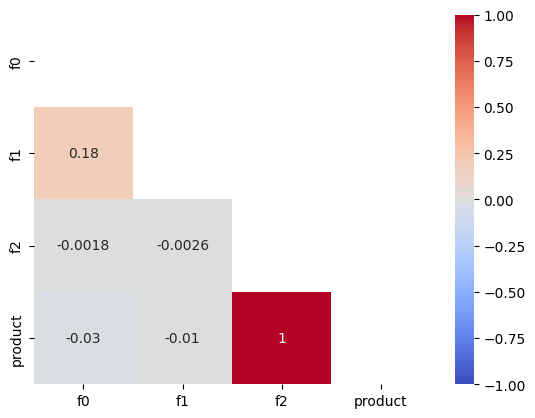

In [60]:
corr_features(df2)

Максимальный коэф. корреляции между признаками 0.18 (f0 и f1). Очень странно видеть коэф.корреляции 1 у f2 и таргета (product). В задании было указано, что эти данные синтетические. В жизни такие вряд ли будут)

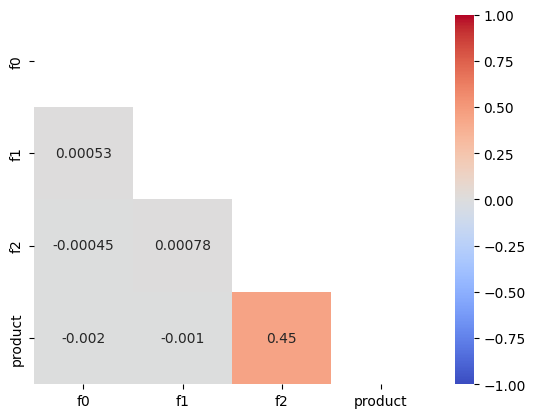

In [61]:
corr_features(df3)

Между признаками коэф. корреляции очень слабые. С таргетом хорошо коррелирует признак f2(0.45).

### Вывод

1. У нас есть 3 датасета с размерами 100тыс. строк и 4 основные признака (один из которых целевой - product) + id.  
2. Пропусков, дубликатов нет.
3. Смущает странные распределения f2 и product во втором датасете. И коэф. корреляции между ними 1. Это неестественно. Мое объяснение - синтетические данные, для этого датасета не совсем удачно сгенерированные.  
4. Сильных зависимостей между признаками нет.

### Подготовка данных к обучению модели

In [62]:
# напишем функцию для деления датафрейма на features/target с коэф. 0.25
def split_features_target(data, coef):
    target = data['product']
    features = data.drop(['product', 'id'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=coef, 
                                                                                random_state=RANDOM_STATE)
    return features_train, features_valid, target_train, target_valid
    

In [63]:
feat_train_1, feat_valid_1, target_train_1, target_valid_1 = split_features_target(df1, 0.25)

In [64]:
feat_train_2, feat_valid_2, target_train_2, target_valid_2 = split_features_target(df2, 0.25)

In [65]:
feat_train_3, feat_valid_3, target_train_3, target_valid_3 = split_features_target(df3, 0.25)

In [66]:
# check
target_valid_1

36340     27.671557
67280    165.908101
97694    121.001842
51303     56.963438
71874     75.223567
            ...    
47757     83.662206
58516    152.451945
45075     20.688438
59132     63.982049
53895     65.385211
Name: product, Length: 25000, dtype: float64

In [67]:
# check
target_train_1.head()

50177    121.610860
73464    132.830492
83834    133.585537
4689     121.279285
46028     56.675155
Name: product, dtype: float64

## Обучение и проверка модели

In [68]:
# создадим функцию для обучения модели, записи метрик, предиктов
def fit_and_score(features_train, features_valid, target_train, target_valid):
    model = LinearRegression().fit(features_train, target_train)
    predict = model.predict(features_valid)
    r2 = model.score(features_valid, target_valid)
    pred_mean = predict.mean()
    rmse = (mean_squared_error(target_valid, predict))**0.5
    data = pd.DataFrame({'r2': [r2], 'rmse': [rmse], 'Средний запас предск.сырья, тыс.бар.': [pred_mean]}).round(4)
    display(data)
    return model, predict, r2, pred_mean, rmse

In [69]:
model_1, pred_1, r2_1, pred_mean_1, rmse_1 = fit_and_score(feat_train_1, feat_valid_1, target_train_1, target_valid_1)

,r2,rmse,"Средний запас предск.сырья, тыс.бар."
0,0.2778,37.5755,92.4153


In [70]:
model_2, pred_2, r2_2, pred_mean_2, rmse_2 = fit_and_score(feat_train_2, feat_valid_2, target_train_2, target_valid_2)

,r2,rmse,"Средний запас предск.сырья, тыс.бар."
0,0.9996,0.8927,68.6727


In [71]:
model_3, pred_3, r2_3, pred_mean_3, rmse_3 = fit_and_score(feat_train_3, feat_valid_3, target_train_3, target_valid_3)

,r2,rmse,"Средний запас предск.сырья, тыс.бар."
0,0.1947,40.114,94.9082


### Вывод

1. Коэффициент детерминации невероятно высокий 0.9996 у модели второго региона - благодаря коэф. корреляции 1 (между f2 и product). У модели первого региона 0.2778, самый скромный у модели 3 региона 0.1947.  
2. Минимальная rmse у модели первого региона 37.58, далее по возрастанию идут третий (40.11) и второй (0.8927).  
3. Средний предсказанный запас сырья в тыс. баррелей: третий регион (94.91), первый (92.42), второй (68.67).  

**Основные показатели моделей по трем регионам**

|Регион    | R2        |  RMSE       |Средний запас предсказанного сырья, тыс.баррелей  |
|----------|-----------|-------------|--------------------------------------------------|
|регион 1 | 0.2778 |37.58 | 92.4153|
|регион 2 |0.9996|0.8927|68.6727|
|регион 3 |0.1947|40.114|94.9082|

## Подготовка к расчёту прибыли

In [72]:
BUDGET = 10**10
PRICE_PER_1000_BARREL = 450000

In [73]:
# посчитаем безубыточный запас сырья в тыс. баррелей для каждой вышки
stock = BUDGET / (PRICE_PER_1000_BARREL*200)
stock

111.11111111111111

In [74]:
labels = ['регион 1', 'регион 2', 'регион 3', 'запас безубыточности']
values = [pred_mean_1, pred_mean_2, pred_mean_3, stock]

fig = go.Figure(data=[go.Bar(x = labels, y = values)])
fig.update_layout(
        title="Средний запас предсказанного сырья",
        title_x = 0.5,
        yaxis_title="тыс. баррелей",
        barmode='overlay',
        margin=dict(l=0, r=0, t=40, b=0))
fig.show()

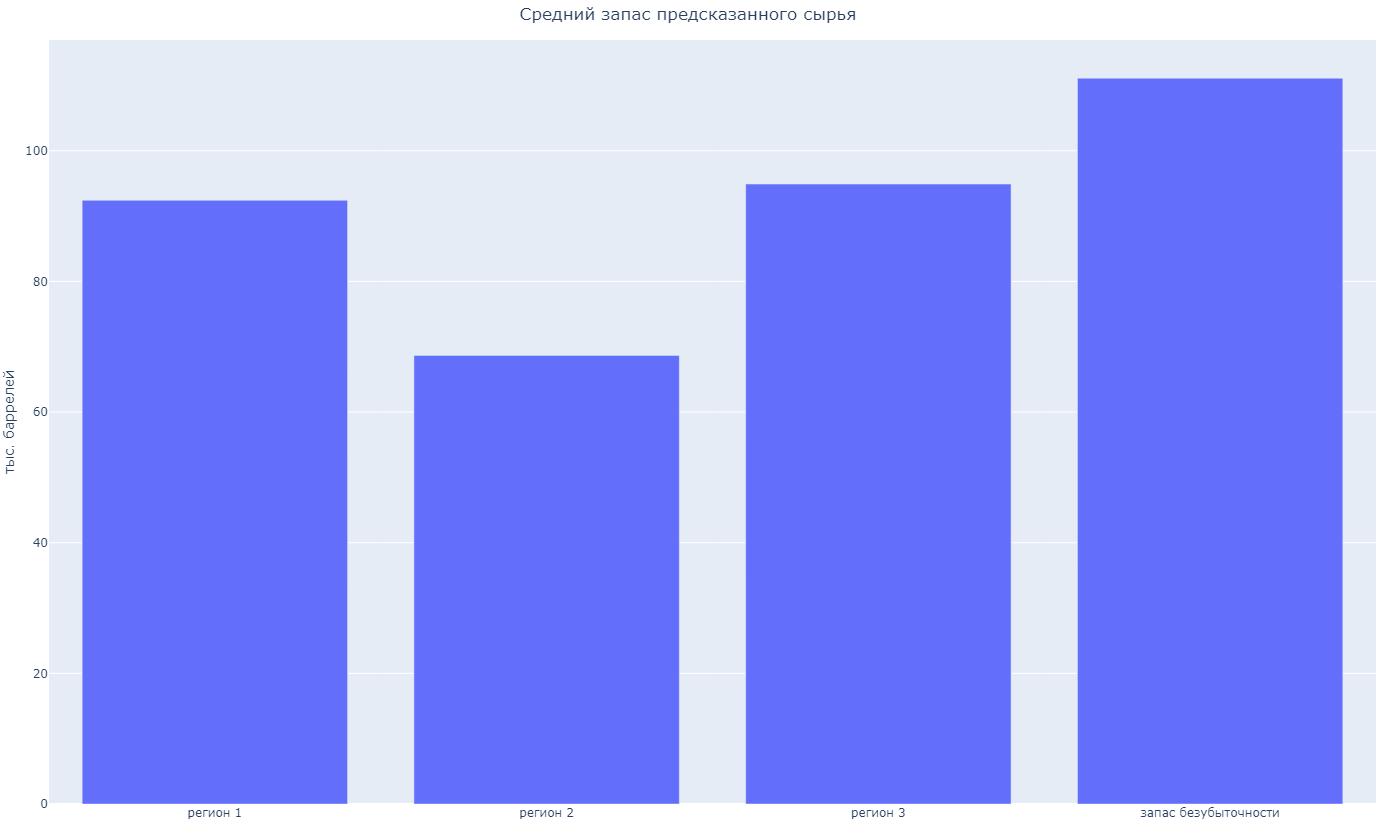

In [75]:
labels = ['регион 1', 'регион 2', 'регион 3', 'запас безубыточности']
values = [target_1.mean(), target_2.mean(), target_3.mean(), stock]

fig = go.Figure(data=[go.Bar(x = labels, y = values)])
fig.update_layout(
        title="Средний запас сырья по таргету",
        title_x = 0.5,
        yaxis_title="тыс. баррелей",
        legend=dict(x=.5, xanchor="center", orientation="h"),
        barmode='overlay',
        margin=dict(l=0, r=0, t=30, b=0))

fig.show()

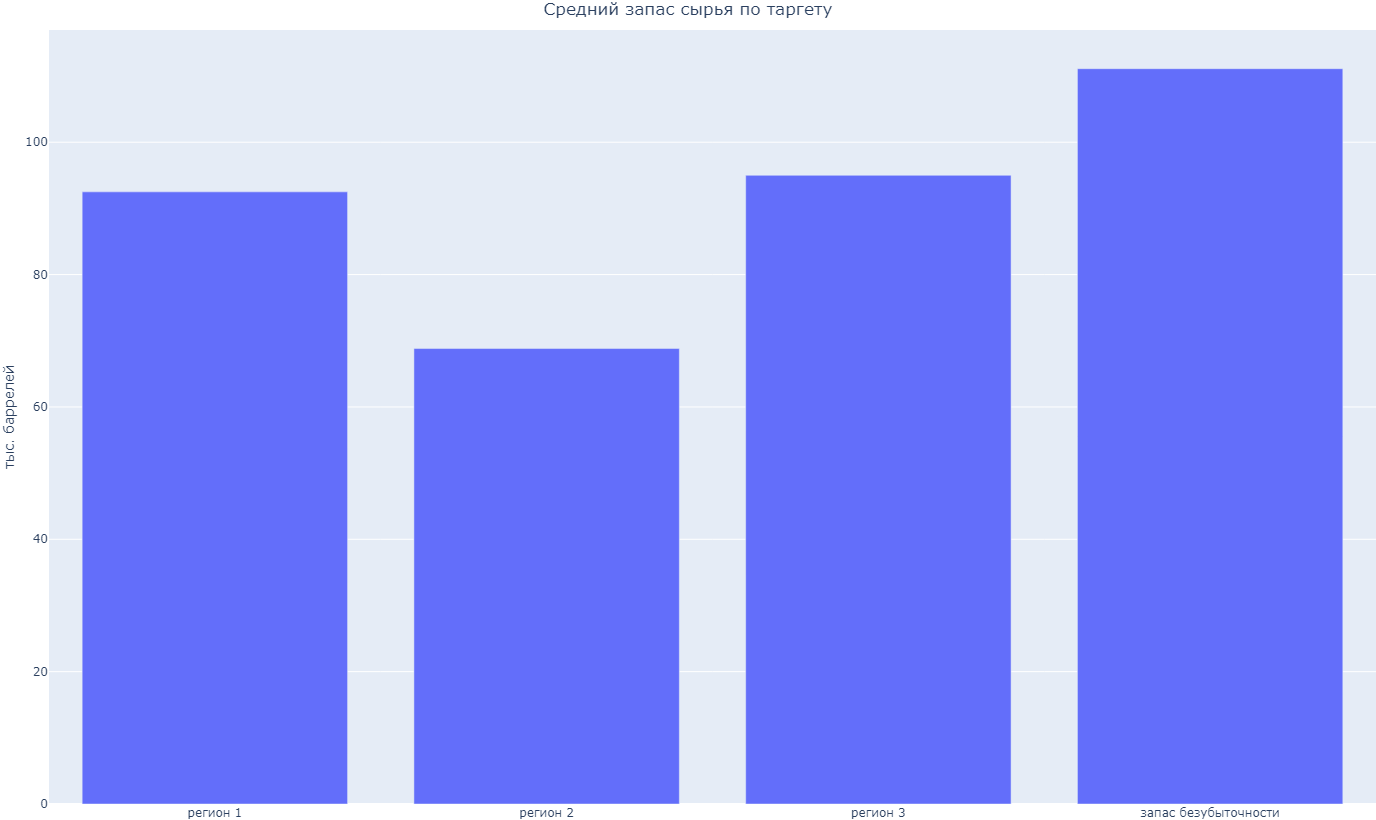

### Вывод

Средний запас предсказанного сырья всех регионов ниже уровня безубыточности. Если смотреть по средний запас по таргету - он также ниже во всех регионах, чем запас безубыточности. Наибольший средний запас у третьего региона, наименьший - у второго.

## Расчёт прибыли и рисков 

In [76]:
# функция для расчета прибыли
def profit(predict, target):
    pred_200_best = predict.sort_values(ascending=False)[:200]
    volume = target[pred_200_best.index].sum()
    profit = volume * PRICE_PER_1000_BARREL - BUDGET
    return profit

In [77]:
state = RandomState(100500)

In [78]:
# подготовим данные для корректной работы с индексами
pred_1 = pd.Series(pred_1)
pred_2 = pd.Series(pred_2)
pred_3 = pd.Series(pred_3)
target_valid_1 = target_valid_1.reset_index(drop=True)
target_valid_2 = target_valid_2.reset_index(drop=True)
target_valid_3 = target_valid_3.reset_index(drop=True)

In [79]:
# chek
target_valid_1

0         27.671557
1        165.908101
2        121.001842
3         56.963438
4         75.223567
            ...    
24995     83.662206
24996    152.451945
24997     20.688438
24998     63.982049
24999     65.385211
Name: product, Length: 25000, dtype: float64

In [80]:
# check
pred_1

0         51.543962
1        117.061689
2         48.779390
3         44.356555
4         77.382501
            ...    
24995     89.283519
24996     91.932722
24997     73.109890
24998     74.274137
24999     95.490223
Length: 25000, dtype: float64

In [81]:
# создаем итоговый фрейм с метриками, которые заполним ниже (сначала нулями)
comparison = pd.DataFrame({'Средняя прибыль, руб.': np.zeros(3),
                          'Квантиль 2.5%': np.zeros(3),
                          'Квантиль 97.5%': np.zeros(3),
                          'Вероятность убытков, %': np.zeros(3)}, index=['регион_1', 'регион_2', 'регион_3'])

In [82]:
# цикл формирования выборок методом бутстреп, расчета метрик, построения гистограм прибыли
for i in range(1, 4):
    
    # bootstrap
    vars()['values_' + str(i)] = []
    
    for j in range(1000):
        
        subsample = vars()['pred_' + str(i)].sample(n=500, replace=True, random_state=state)
        target_subsample = vars()['target_valid_' + str(i)][subsample.index]
        
        # сбросим индексы, чтобы не было повторяющихся
        subsample = subsample.reset_index(drop=True)
        target_subsample = target_subsample.reset_index(drop=True)
        
        prof = profit(subsample, target_subsample)
        vars()['values_' + str(i)].append(prof)
        
    # список values преобразуем в Series
    vars()['values_' + str(i)] = pd.Series(vars()['values_' + str(i)])
    
    # находим среднее значение прибыли для региона
    vars()['profit_mean_' + str(i)] = vars()['values_' + str(i)].mean()
    
    # нижняя граница дов.инт. (2.5% квантиль)
    vars()['lower_' + str(i)] = vars()['values_' + str(i)].quantile(0.025)
    
    # верхняя граница дов.инт. (97.5% квантиль)
    vars()['upper_' + str(i)] = vars()['values_' + str(i)].quantile(0.975)
    
    # убытки
    vars()['negative_values_' + str(i)] = vars()['values_' + str(i)].loc[vars()['values_' + str(i)] < 0]
    
    # построение гистограммы прибыли, убытков, доверительного интервала
    
    fig = go.Figure()
    # строим гистограмму прибыли
    fig.add_trace(go.Histogram(x=vars()['values_' + str(i)], opacity=0.75, name='положительная прибыль'))
    # строим гистограмму убытков
    fig.add_trace(go.Histogram(x=vars()['negative_values_' + str(i)], opacity=0.75, name='отрицательная прибыль'))
    # отмечаем нижнюю границу дов.инт.
    fig.add_vline(x=vars()['lower_' + str(i)], line_width=2, line_dash="dash", line_color="green")
    # отмечаем верхнюю границу дов.инт.
    fig.add_vline(x=vars()['upper_' + str(i)], line_width=2, line_dash="dash", line_color="green")
    fig.update_layout(
        title=f"Гистограмма прибыли 200 лучших скважин региона {i}",
        title_x = 0.5,
        xaxis_title="Прибыль",
        legend=dict(x=.5, xanchor="center", orientation="h"),
        barmode='overlay',
        margin=dict(l=0, r=0, t=30, b=0))

    fig.show()
    
    # считаем вероятность убытков
    vars()['prob_loss_' + str(i)] = len(vars()['negative_values_' + str(i)]) / len(vars()['values_' + str(i)]) * 100
    
    # заполняем таблицу данными
    comparison.iloc[i-1, 0] = vars()['profit_mean_' + str(i)]
    comparison.iloc[i-1, 1] = vars()['lower_' + str(i)]
    comparison.iloc[i-1, 2] = vars()['upper_' + str(i)]
    comparison.iloc[i-1, 3] = vars()['prob_loss_' + str(i)]
    

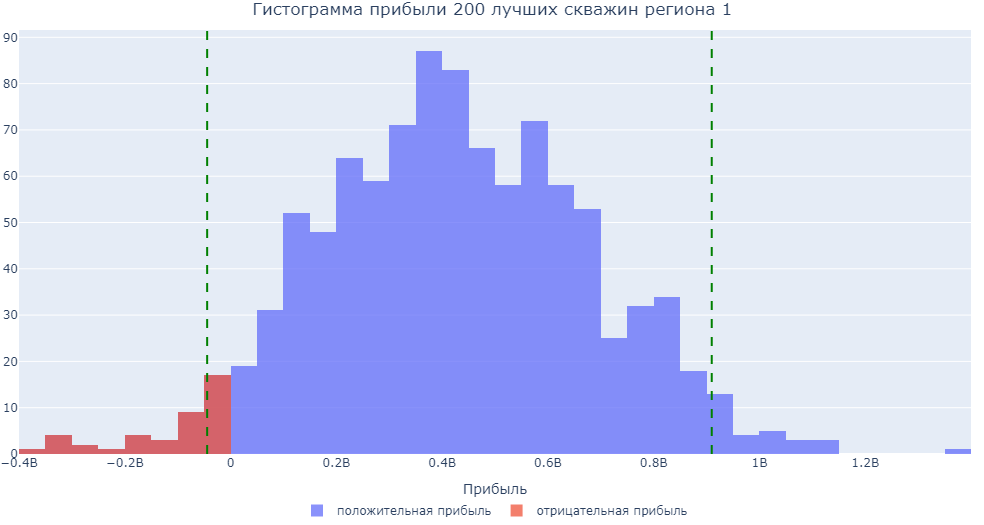

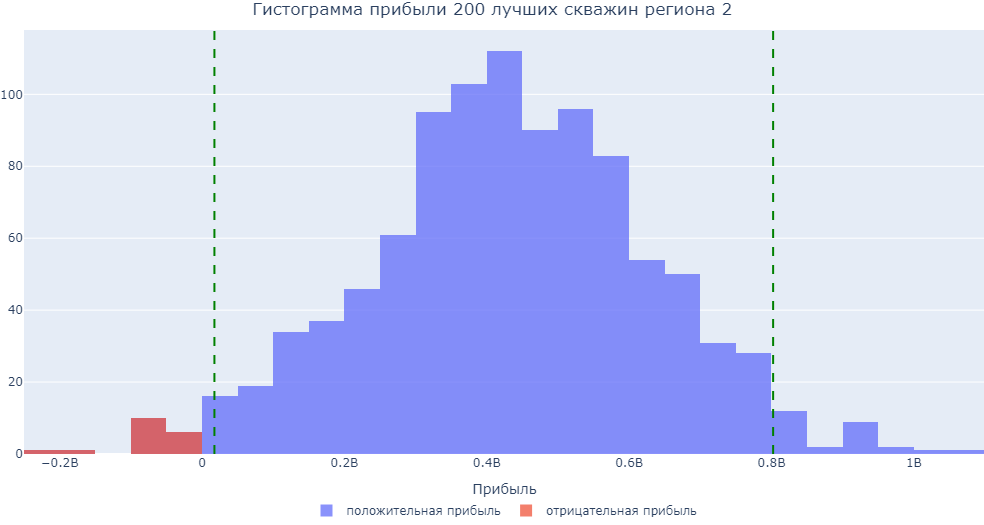

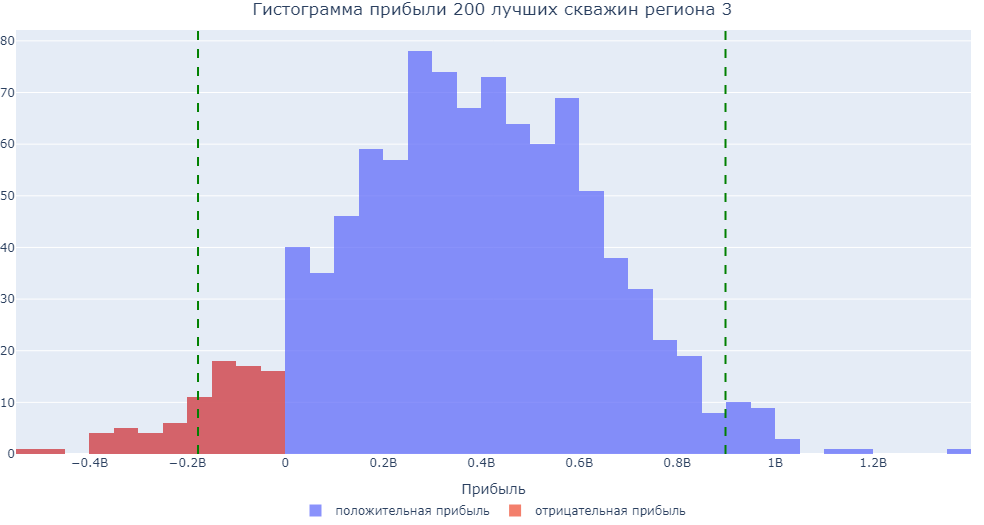

In [83]:
comparison

,"Средняя прибыль, руб.",Квантиль 2.5%,Квантиль 97.5%,"Вероятность убытков, %"
регион_1,4.250373e+08,-4.424168e+07,9.098090e+08,4.1
регион_2,4.325615e+08,1.749616e+07,8.023616e+08,1.8
регион_3,3.689507e+08,-1.783384e+08,8.987311e+08,8.3


Первый и третий регионы с вероятностью убытков более 2.5% (4.1% и 8.3%). Второй регион выигрывает и по самой низкой вероятности убытков (1.8%) и по средней прибыли 200 лучших скважин 4.33*10^8 руб.